In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import healpy as hp
from scipy.optimize import fsolve, least_squares, minimize, differential_evolution
import tqdm


sys.path.append('../pipeline_scripts/')
from pipeline_main import serialize_dictionary, pipeline
from pipeline_streamers import accretion_pattern
from plotting_setup import *


In [2]:
data = pipeline(snap = 512, run = 'sink13fmr05', sink_id=13)

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:20<00:00, 206.05it/s]


In [3]:
data.recalc_L(verbose = 0)
data.calc_disksize(verbose=0, radial_bins=1000, r_in=5, radius=1000, plot=False, avg_cells=50)
data.calc_trans_xyz(verbose = 0)

100%|██████████| 4165/4165 [00:01<00:00, 2963.17it/s]


In [3]:
map_data = serialize_dictionary(filename = 'sink13fmr05_accretion_maps_defsys2.pkl', store = False)

In [4]:
map_data.keys()

dict_keys(['time', 'maps', 'nside', 'radius'])

In [5]:
time_0 = map_data['time']


bool = (map_data['time'] != 0) & ~np.isnan(map_data['radius'])

time = map_data['time'][bool]
radius = map_data['radius'][bool]
nside_array = map_data['nside'][bool]
maps = [map_data['maps'][i] for i in np.asarray(np.where(bool)).squeeze()]


In [6]:
for i, r in enumerate(radius[:10]):
    if i == 3: continue
    map, nside , cell_level = data.accretion_pattern(shell_r = r , verbose=1)
    print(nside, cell_level.mean())


  0%|          | 0/41 [00:00<?, ?it/s]


AttributeError: '_patch' object has no attribute 'trans_xyz'

[Text(0.5, 0, 'Time [kyr]'), Text(0, 0.5, 'Disk radius [au]')]

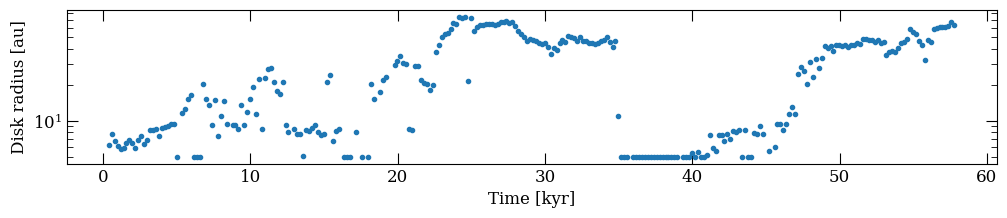

In [7]:
fig, axs = plt.subplots(figsize = (12,2))

axs.semilogy(time * 1e-3, radius, '.')
axs.set(xlabel = 'Time [kyr]', ylabel = 'Disk radius [au]')

In [9]:
infall = {t: [] for t in range(len(time))}
for i, nside in enumerate(nside_array):
    npix = hp.nside2npix(int(nside))
    Lat = np.unique(hp.pix2ang(int(nside), np.arange(npix))[0]) - np.pi/2
    infall[i] = np.zeros(len(Lat) - 1)

In [10]:
pct = np.array([25, 50, 75, 100])
area_data = np.zeros((len(pct), len(time)))
pct_in = np.zeros_like(time)
cum_lat = np.zeros_like(area_data)
sec_lat = np.zeros_like(area_data)
out_lat = np.zeros_like(time)
acc = np.zeros_like(time)
out = np.zeros_like(time)

for t in tqdm.tqdm(range(len(time))):

    shell_r = radius[t] / data.au_length
    nside = int(nside_array[t])
    npix = hp.nside2npix(int(nside))

    map = maps[t]
    bool_pos = map > 0; bool_neg = map < 0
    inflow_pixels = map[bool_pos]
    outflow_pixels = map[bool_neg]

    acc[t] = np.sum(inflow_pixels); out[t] = np.sum(outflow_pixels)

    Lat_in, _ = hp.pix2ang(nside, np.arange(npix)[bool_pos]) 
    Lat_out, _ = hp.pix2ang(nside, np.arange(npix)[bool_neg]) 
    infall_index = np.argsort(inflow_pixels)[::-1]

    pct_in[t] = len(Lat_in) / npix * 100

    cell_area = hp.nside2pixarea(nside) * shell_r**2

    sphere_area = cell_area * npix 

    x = np.arange(len(inflow_pixels)) * cell_area / sphere_area * 100
    y = np.cumsum(inflow_pixels[infall_index]) / np.sum(inflow_pixels) * 100

    if len(y) == 0: continue

    indicies = [np.argmin(abs(y - p)) for p in pct]    
    area_data[:,t] = x[indicies]

    cum_lat[:,t] = [np.average(Lat_in[infall_index][:j], weights=inflow_pixels[infall_index][:j]) for j in indicies]
    out_lat[t] = np.average(Lat_out)#, weights=outflow_pixels)

    k0 = 0
    for i, k in enumerate(indicies):
        sec_lat[i,t] = np.average(Lat_in[infall_index][k0:k], weights=inflow_pixels[infall_index][k0:k])
        k0 = k.copy()


100%|██████████| 274/274 [00:00<00:00, 955.50it/s] 


In [11]:
flux = {
    'Inflow': pct_in,
    'Outflow': 100 - pct_in}

In [16]:
acc

array([1.80697127e-05, 1.28800145e-05, 1.57393883e-05, 1.83303571e-05,
       1.97775016e-05, 2.11130144e-05, 1.30760662e-05, 1.29946039e-05,
       1.35462228e-05, 1.77891284e-05, 1.78892087e-05, 1.68048963e-05,
       2.01092862e-05, 1.50291481e-05, 1.74000703e-05, 1.33990882e-05,
       1.33263428e-05, 1.76593993e-05, 1.21763504e-05, 1.51020990e-05,
       2.12776981e-05, 1.77972674e-05, 1.46580499e-05, 1.63806892e-05,
       1.45471204e-05, 1.39217749e-05, 1.05845568e-05, 1.14048379e-05,
       2.66074870e-05, 1.90540508e-05, 2.21862790e-05, 3.30677367e-06,
       1.57620813e-05, 1.34960048e-05, 1.80986938e-05, 8.72276409e-06,
       1.33419042e-05, 1.73625707e-05, 1.56524710e-05, 1.74069329e-05,
       9.83860381e-06, 2.47760966e-05, 1.51666107e-05, 1.07370718e-05,
       1.46694661e-05, 1.59593535e-05, 1.54114367e-05, 1.28237749e-05,
       1.78563523e-05, 1.07492111e-05, 1.33518729e-05, 2.06079443e-05,
       1.23096698e-05, 1.06506070e-05, 1.43280274e-05, 2.27974318e-05,
      

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


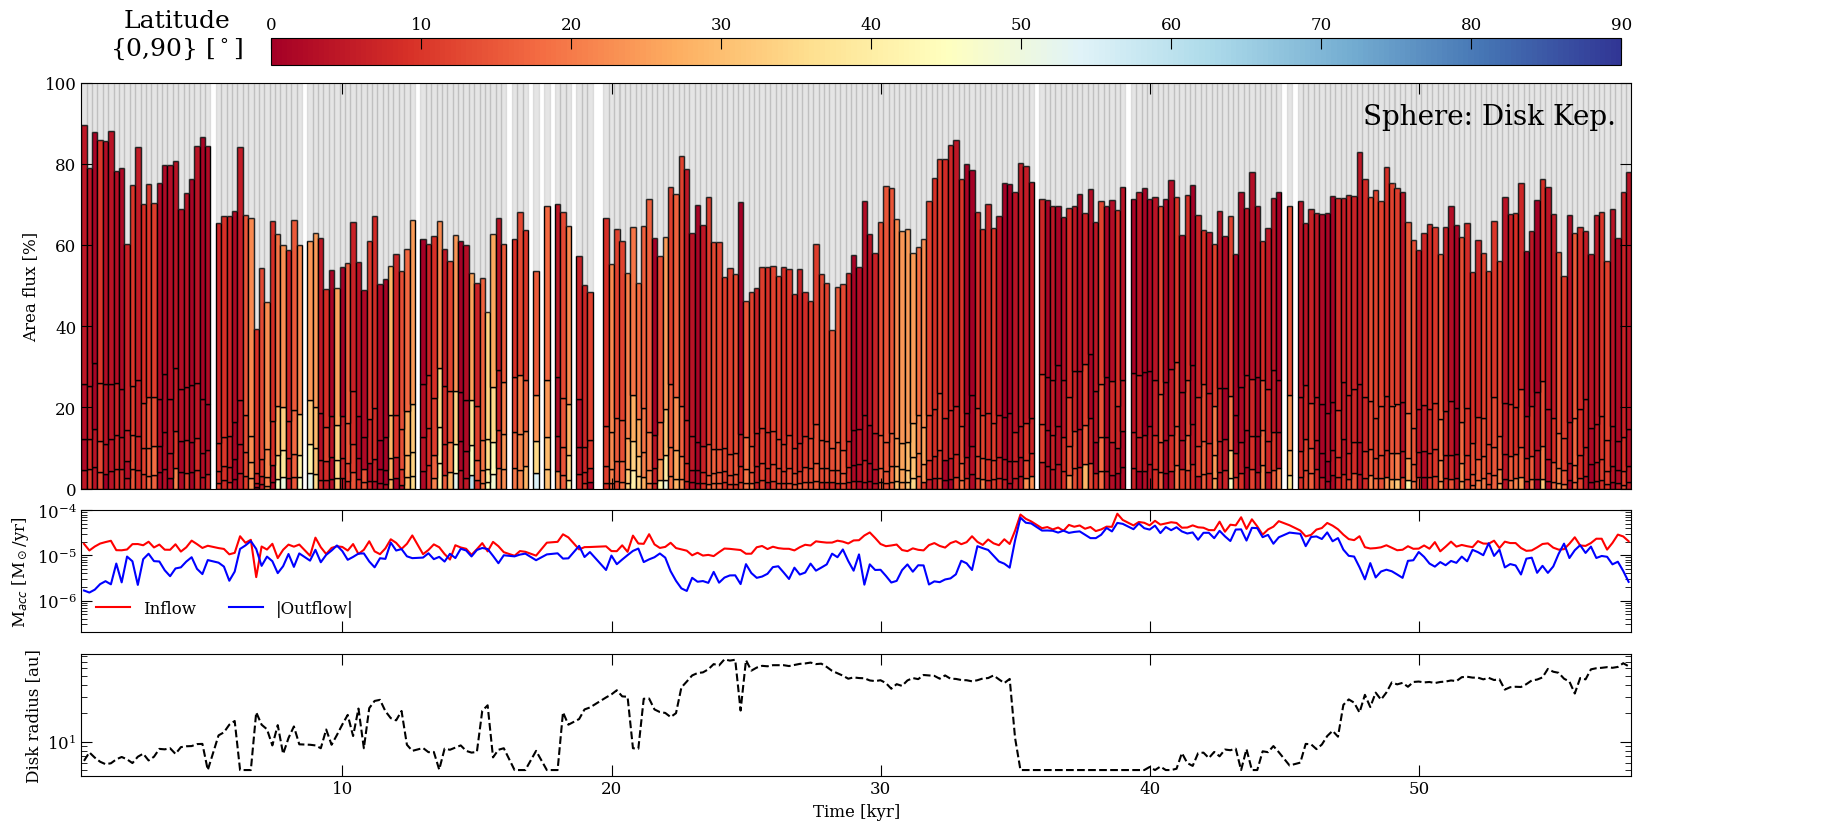

In [20]:
show_outflow_deg = False

fig, ax = plt.subplots(3, 1, figsize = (20,9), gridspec_kw={'height_ratios': [5,1.5,1.5]}, sharex = True)

axs = ax[1]

axs.semilogy(time*1e-3, acc, color = 'red', label = 'Inflow')
axs.semilogy(time*1e-3, abs(out), color = 'blue', label = '|Outflow|')

axs.set(ylabel = 'M$_{acc}$ [M$_\odot$/yr]', ylim = (2e-7, 1e-4))
axs.legend(frameon = False, ncol = 2)


axs = ax[2]
axs.semilogy(time * 1e-3, radius, '--', color = 'black')
axs.set(xlabel = 'Time [kyr]', ylabel = 'Disk radius [au]')


axs = ax[0]
deg_bins = np.linspace(0, 90, 100)
lat_colors = plt.cm.RdYlBu(np.linspace(0,1, 100))

bottom = np.zeros_like(time)
to_bar = np.vstack((area_data[0,:], np.diff(area_data, axis = 0)))


for i, p in enumerate(pct):
    deg = np.rad2deg(abs(cum_lat[i] - np.pi/2))
    bar_color = np.array([np.argmin(abs(deg[t] - deg_bins)) for t in range(len(time))]).copy()
    axs.bar(time*1e-3, to_bar[i,:], width = 0.2, align='center', label = p, bottom=bottom, fill=True, edgecolor = 'black', color = lat_colors[bar_color])
    bottom += to_bar[i,:]


if show_outflow_deg: 
    deg_out = np.rad2deg(abs(out_lat - np.pi/2))
    out_color = np.array([np.argmin(abs(deg_out[t] - deg_bins)) for t in range(len(time))]).copy()
    axs.bar(time*1e-3, flux['Outflow'], width =0.2, align='center', bottom=area_data[-1,:], label = 'Outflow', color = lat_colors[out_color], alpha = 0.5)
else:
    axs.bar(time*1e-3, flux['Outflow'], width =0.2, align='center', bottom=area_data[-1,:], label = 'Outflow', color = 'grey', alpha = 0.2, edgecolor = 'grey')

axs.set(xlim = (time[0]*1e-3-0.1,time[-1]*1e-3+0.1), ylim = (0,100), ylabel = 'Area flux [%]')

cbaxes = fig.add_axes([0.22, 0.9, 0.675, 0.03])
norm = plt.Normalize(vmin=min(deg_bins), vmax=max(deg_bins)) 
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu, norm=norm); sm.set_array([])

cbar = fig.colorbar(sm, cax=cbaxes, orientation='horizontal')  # Create the colorbar
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('Latitude\n{0,90} [$^\circ$]', labelpad = -40, x = -0.07, rotation = 0, fontsize = 18)

axs.text(0.99, 0.95, 'Sphere: Disk Kep.', transform=axs.transAxes, ha='right', va='top', fontsize = 20)

plt.legend(loc = 'upper right', bbox_to_anchor = (1.15,1), frameon = False)

fig.subplots_adjust(wspace=0, hspace=0.1)